

# <span style="color:#336699">VHI Reference values (1991-2020)</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
   
<br/>

<b>Abstract.</b> This Jupyter Notebook derives the 15th percentile and minimal VHI values on a monthly and daily basis and deals with missing values.


<br/>


In [1]:
import ee
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
# GEE credentials
config = r'D:\Users\joan-sturm-w1\Documents\GitHub\topo-satromo\secrets\geetest-credentials-int.secret'

Initialize Google Earth Engine (GEE)

In [3]:
def initialize_gee_and_drive():
    """
    Initializes and authenticates Google Earth Engine (GEE) and Google Drive APIs using service account credentials.
    
    This function:
    1. Sets up authentication scopes for Google Drive
    2. Reads service account key file from the config path
    3. Authenticates with Google Drive using the service account credentials
    4. Initializes Google Earth Engine with the same credentials
    5. Performs a test query to verify GEE initialization was successful
    
    Requirements:
        - PyDrive (for Google Drive authentication)
        - Earth Engine Python API (ee)
        - oauth2client (for ServiceAccountCredentials)
        - Valid service account key file path in config variable
    
    Returns:
        None. Prints confirmation message if initialization was successful or failure message otherwise.
    
    Raises:
        FileNotFoundError: If the service account key file cannot be found
        JSONDecodeError: If the service account key file is not valid JSON
        EEException: If Earth Engine initialization fails
    """
    # Set scopes for Google Drive
    scopes = ["https://www.googleapis.com/auth/drive"]

    # Initialize GEE and authenticate using the service account key file

    # Read the service account key file
    with open(config, "r") as f:
        data = json.load(f)

    # Authenticate with Google using the service account key file
    gauth = GoogleAuth()
    gauth.service_account_file = config
    gauth.service_account_email = data["client_email"]
    gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(
        gauth.service_account_file, scopes=scopes
    )

    # Initialize Google Earth Engine
    credentials = ee.ServiceAccountCredentials(
        gauth.service_account_email, gauth.service_account_file
    )
    ee.Initialize(credentials)

    # Test if GEE initialization is successful
    image = ee.Image("NASA/NASADEM_HGT/001")
    title = image.get("title").getInfo()

    if title == "NASADEM: NASA NASADEM Digital Elevation 30m":
        print("GEE initialization successful")
    else:
        print("GEE initialization FAILED")

# Authenticate with GEE and GDRIVE
initialize_gee_and_drive()

GEE initialization successful


<hr style="border:1px solid #0077b9;">

### Defining collections, time and other variables:

In [4]:
# Load the warn regions feature and VHI image collections
regions = ee.FeatureCollection('projects/satromo-prod/assets/res/warnregionen_vhi_2056')
imgCollection = ee.ImageCollection('projects/satromo-prod/assets/col/VHI_HIST_SWISS')

# Set the parameters
landCover = 'VEGETATION'  # Possibilities 'VEGETATION', 'FOREST'
# valid_pixel_threshold = 20  # Percentage of vegetated pixels required
# moy = 12  # month of the year

# Set the time period
startDate = '1991-01-01'
endDate = '2020-12-31'
# monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# monthName = monthNames[moy - 1]  # indexing starts at 0

### VHI Collection
Filter for time frame, region, etc.

In [11]:
# Filter the regions feature collection to isolate target region
region_nr = 36 #[31-69]  
region_feature = regions.filter(ee.Filter.eq('REGION_NR', region_nr)).first()

# Get the region geometry
region_geometry = region_feature.geometry()

# Load the VHI collection and filter by land cover type
vhiCollection = imgCollection \
    .filter(ee.Filter.stringContains('system:index', landCover)) \
    .filterDate(startDate, endDate) \
    .filterBounds(region_geometry)
vhiCollection = vhiCollection.select('vhi')

region_name = region_feature.get('Name').getInfo()
print(f"Analyzing region: {region_nr} - {region_name}")

Analyzing region: 36 - Greyerzerland


Extracting mean VHI out of all valid pixels:

In [12]:
# Mask invalid values (outside 0-100 range)
def mask_invalid_values(image):
    # Create a mask where VHI values are between 0 and 100
    valid_mask = image.gte(0).And(image.lte(100))
    # Apply the mask to the image
    return image.updateMask(valid_mask)

# Apply masking to the collection
masked_vhi_collection = vhiCollection.map(mask_invalid_values)

# Function to calculate multiple statistics for each image
def calculate_stats(image):
    # Get the region stats with multiple reducers
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.count(), None, True)
            .combine(ee.Reducer.min(), None, True)
            .combine(ee.Reducer.percentile([15]), None, True),
        geometry=region_geometry,
        scale=250,  # Adjust based on your data's resolution
        maxPixels=1e9
    )
    
    # Get image date
    date = ee.Date(image.get('system:time_start'))
    
    # Return a feature with the stats
    return ee.Feature(None, {
        'date': date.format('YYYY-MM-dd'),
        'mean': stats.get('vhi_mean'),
        'min': stats.get('vhi_min'),
        'p15': stats.get('vhi_p15'),  # 15th percentile
        'count': stats.get('vhi_count'),
        'timestamp': image.get('system:time_start')
    })

# Apply the stats calculation to each image
stats_collection = ee.FeatureCollection(masked_vhi_collection.map(calculate_stats))

# Sort by timestamp
stats_collection = stats_collection.sort('timestamp')

# Convert to a list for processing
stats_list = stats_collection.toList(stats_collection.size())

# Get the stats as a list of dictionaries
stats_data = stats_list.getInfo()

# Extract the data for plotting
dates = [stat['properties']['date'] for stat in stats_data]
means = [stat['properties']['mean'] for stat in stats_data]
mins = [stat['properties']['min'] for stat in stats_data]
p15s = [stat['properties']['p15'] for stat in stats_data]
counts = [stat['properties']['count'] for stat in stats_data]

print(f"Total number of images processed: {len(dates)}")

Total number of images processed: 360


### Plot the time series

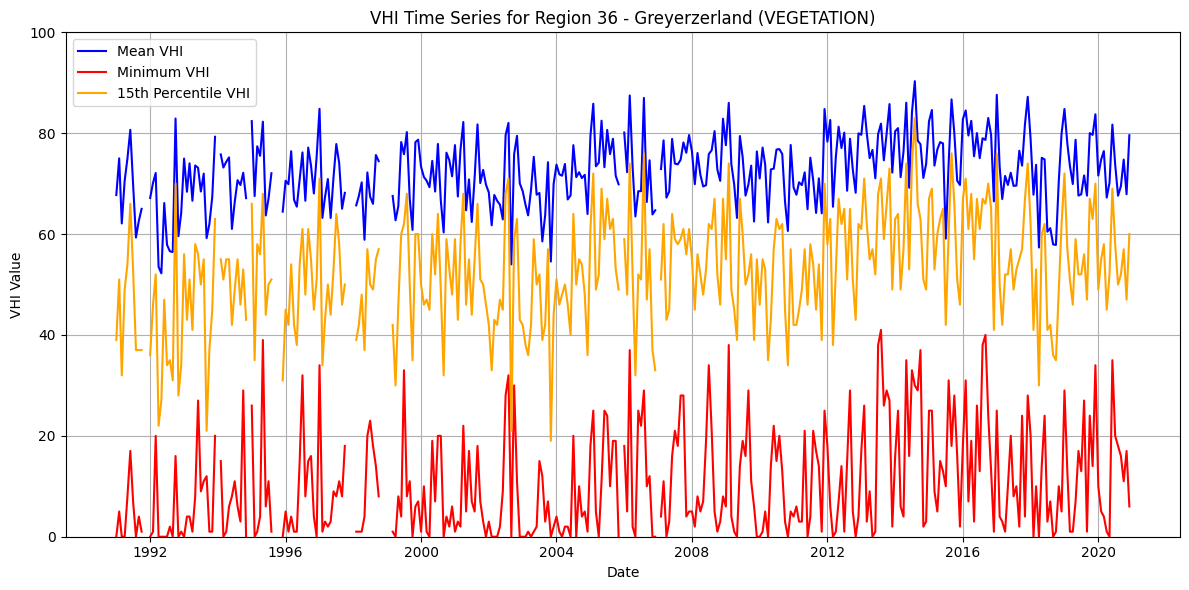

In [16]:
# Convert string dates to datetime objects for better plotting
datetime_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Plot time series with mean, min, and 15th percentile
plt.figure(figsize=(12, 6))
plt.plot(datetime_dates, means, label='Mean VHI', color='blue')
plt.plot(datetime_dates, mins, label='Minimum VHI', color='red')
plt.plot(datetime_dates, p15s, label='15th Percentile VHI', color='orange')

plt.title(f'VHI Time Series for Region {region_nr} - {region_name} ({landCover})')
plt.xlabel('Date')
plt.ylim(0, 100)
plt.ylabel('VHI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

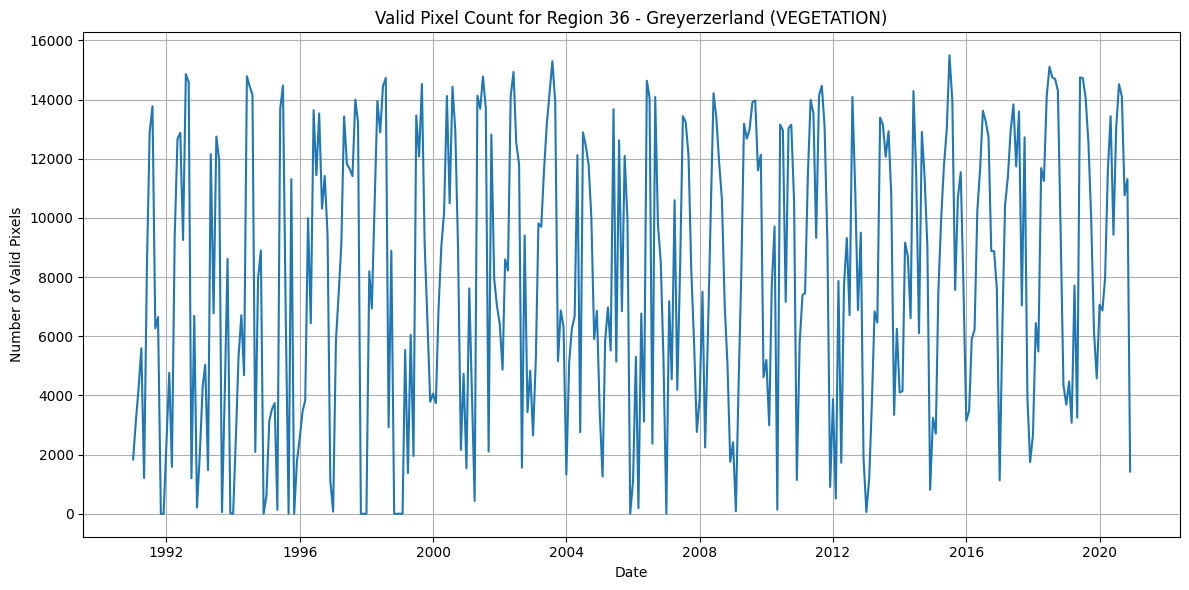

In [14]:
# Optional: Plot the count of valid pixels over time
plt.figure(figsize=(12, 6))
plt.plot(datetime_dates, counts)
plt.title(f'Valid Pixel Count for Region {region_nr} - {region_name} ({landCover})')
plt.xlabel('Date')
plt.ylabel('Number of Valid Pixels')
plt.grid(True)
plt.tight_layout()
plt.show()